<header style="font-family:Arial Narrow;">
    <br>
    <aside style="float:left">
        <a href="https://www.usgs.gov/centers/cm-water">
            <img src="https://upload.wikimedia.org/wikipedia/commons/0/08/USGS_logo.png" alt="USGS" style="height: 80px;">
        </a>
    </aside>
    <aside style="float:right">
        <a href="https://www2.illinois.gov/epa/Pages/default.aspx"><img src="https://www2.illinois.gov/epa/Style%20Library/SOISierra/Images/SiteLogo.png" alt="Illinois EPA"  style="height: 80px;"></a>
    </aside>
    
   
    <div style="clear:both;">
        <hr style="background-color:black;">
        <h1 style="font-weight:bold; font-size:26pt" property="headline">Nitrate and Phosphorus Loads from Illinois Rivers</h1>
        <h2 style="font-weight:bold" property="alternativeHeadline">Water Year 2021 Update</h2>
        <address>
            <a property="author">Timothy O. Hodson<sup>1</sup></a>
            <br />  <sup>1</sup><a>U.S. Geological Survey Central Midwest Water Science Center</a>
        </address>
 
   </div>
   <br>
</header>

To help enable reproducible cutting-edge science, USGS will work to establish a community testbed for sharing data and workflows used in Illinois nutrient monitoring. This notebook demonstrates the basic concepts of
1. making all data available from the cloud in analysis ready formats;
2. running notebooks locally or in the cloud to generate reports, run models, or create interactive web applets; and
3. enabling anyone to share, run, and modify notebooks using only a web browser.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/illinois-nutrient-monitoring/biennial-report/blob/master/notebooks/01_report_plots.ipynb)  


## Environment Setup

In [102]:
%%capture
!pip install https://github.com/aleaf/Figures/archive/master.zip
!pip install titlecase
    
import matplotlib.pyplot as plt
from Figures import ReportFigures

%matplotlib inline
rf = ReportFigures()
rf.set_style()

# configure fonts for presentation
import matplotlib.pyplot as plt


fig_w = 5.51181
fig_h = 4

In [103]:
# run for in-notebook presentation
SMALL_SIZE = 10
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE = MEDIUM_SIZE + 2

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

save_figures = True
figure_count = 0
# set figure dimensions
#fig_w = 10
#fig_h = 8


In [104]:

# load libraries
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import json
import xarray as xr
import pint_xarray
from titlecase import titlecase

import warnings
warnings.filterwarnings("ignore", message="the unit of the quantity is stripped when downcasting to ndarray")

# load helper functions
from nmc import *
from nmc_plot import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Datasets

In [105]:
supergage_metadata = '../../data/supergage_network.json'
ambient_metadata = '../../data/ambient_network.json'

with open(supergage_metadata) as f:
    supergage_network = json.load(f)
    
with open(ambient_metadata) as f:
    ambient_network = json.load(f)

supergage_ds = xr.load_dataset('../../data/supergage_annual_loads.netcdf')
ambient_ds = xr.load_dataset('../../data/ambient_wrtdsk_annual_loads.netcdf')

labels(ambient_network)

['Rock at Joslin',
 'Green at Geneseo',
 'Illinois at Valley City',
 'Kaskaskia at Venedy Station',
 'Big Muddy at Murphysboro',
 'Little Wabash at Carmi',
 'Embarras at Ste. Mairie',
 'Vermilion at Danville']

Compute loads from monitoring network

In [89]:
# define study period
baseline_years = np.arange(1984,1996+1)
study_years = np.arange(2017,2021+1)

# scale loads based on state's contributing drainage
# nested=False, so don't subtract off Rock at Rockton
supergage_loads = compute_network_loads(supergage_ds.dropna(dim='year'), supergage_network, nested=False)

ambient_loads = compute_network_loads(ambient_ds.sel(site_no=gages(ambient_network)).dropna(dim='year'),
                                      ambient_network, nested=False)

# compute baseline mean annual load
baseline_mean_load = ambient_loads.sel(river=labels(ambient_network)).sum(dim='river').sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean()

# convert loads to percentages
ambient_total_load_p = ambient_loads.sum(dim='river')/ baseline_mean_load * 100 - 100
supergage_total_load_p = supergage_loads.sum(dim='river')/ baseline_mean_load * 100 - 100

## Methods
Replicates methods from previous biennial reports, except
- baseline period: water years 1984–1996 
- current period: water years 2017–2022
- no subtraction for Rock River
- incorporation of continuous water quality data


## Results
### Statewide Nitrate Load

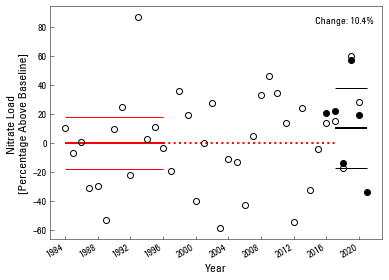

In [92]:
parameter='nitrate'
loc='upper right'

fig, ax = plt.subplots(figsize=(fig_w, fig_h))


running_average_plot(ds1=ambient_total_load_p[parameter],
                     period1=baseline_years,
                     period2=study_years,
                     ds2=supergage_total_load_p[parameter], #comment this for ambient only
                     loc=loc,
                     ax=ax)

text = ax.set_ylabel(f'{parameter} load \n[percentage above baseline]'.title())
fig.tight_layout()
str(figure_count).rjust(2,'0')

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_annual_{parameter}_load.png', dpi=150)
    figure_count += 1 

### Statewide Phosphorus Load

In [106]:
parameter='phosphorus'
loc='upper left'

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

running_average_plot(ds1=ambient_total_load_p[parameter],
                     period1=baseline_years,
                     period2=study_years,
                     ds2=supergage_total_load_p[parameter], #comment this for ambient only
                     loc=loc,
                     ax=ax)

text = ax.set_ylabel(f'{parameter} load \n[percentage above baseline]'.title())
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_annual_{parameter}_load.png', dpi=150)
    figure_count += 1 

SyntaxError: invalid syntax (1085271956.py, line 17)

### Breakdown by River Basin

In [62]:
baseline_loads = ambient_loads.sel(year=ambient_loads.year.dt.year.isin(baseline_years))
current_loads = supergage_loads.sel(year=supergage_loads.year.dt.year.isin(study_years))

current_loads.groupby('river').mean(dim='year').to_dataframe()

,nitrate,phosphorus
river,,
Rock at Joslin,4.471938e+07,2.109177e+06
Green at Geneseo,5.260127e+06,2.333940e+05
Illinois at Valley City,8.686752e+07,7.745349e+06
Kaskaskia at Venedy Station,4.801308e+06,2.186158e+06
Big Muddy at Murphysboro,1.402299e+06,6.274682e+05
Little Wabash at Carmi,3.260844e+06,1.475973e+06
Embarras at Ste. Mairie,5.804090e+06,7.066575e+05
Vermilion at Danville,7.466154e+06,3.445904e+05


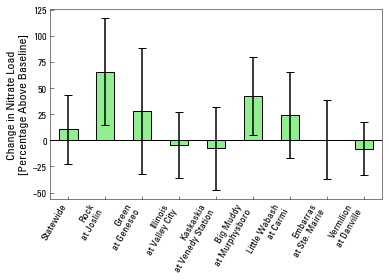

In [63]:
parameter = 'nitrate'

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_loads[parameter], 
                     current_loads[parameter], 
                     color='lightgreen',
                     ax=ax,
                     statewide=False)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
text = ax.set_ylabel(titlecase(f'Change in {parameter} load\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_{parameter}_basin_yield.png', dpi=150)
    figure_count += 1 

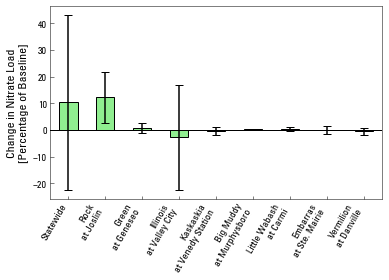

In [64]:
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_loads[parameter], 
                     current_loads[parameter], 
                     color='lightgreen',
                     ax=ax,
                     statewide=True)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
text = ax.set_ylabel(titlecase(f'Change in {parameter} load\n[percentage of baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_{parameter}_basin_load.png', dpi=150)
    figure_count += 1 

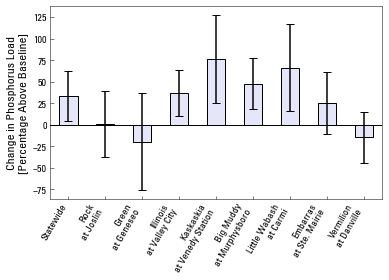

In [65]:
parameter = 'phosphorus'

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_loads[parameter], 
                     current_loads[parameter], 
                     color='lavender',
                     ax=ax,
                     statewide=False)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
text = ax.set_ylabel(titlecase(f'Change in {parameter} load\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_{parameter}_basin_yield.png', dpi=150)
    figure_count += 1 

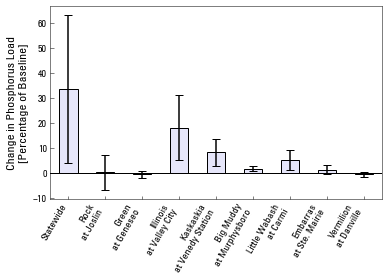

In [66]:
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_loads[parameter], 
                     current_loads[parameter], 
                     color='lavender',
                     ax=ax,
                     statewide=True)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
text = ax.set_ylabel(titlecase(f'Change in {parameter} load\n[percentage of baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_{parameter}_basin_load.png', dpi=150)
    figure_count += 1 

## Streamflow
Download streamflow data from NWIS (U.S. Geological Survey, 2022)

In [67]:
# download flow data 
from dataretrieval import nwis
# begin by downloading flow datga
ambient_gages = gages(ambient_network)
supergage_gages = gages(supergage_network)


start = ambient_loads.year.dt.strftime('%Y')[0] + '-10-01'
start = str(start.values)
end = '2021-09-30'

df, _ = nwis.get_dv(sites=ambient_gages, start=start, end=end, parameterCd='00060')
df = df.rename({'00060_Mean':'mean flow [cfs]'}, axis=1).drop('00060_Mean_cd', axis=1)

#remove timezone because xarray doesn't know how to handle it yet (bug)
df = df.reset_index()
df['datetime'] = df['datetime'].values
df = df.set_index(['site_no','datetime'])

flow_ds = df.to_xarray()
flow_ds['water_year'] = flow_ds.datetime.dt.year.where(flow_ds.datetime.dt.month < 10, flow_ds.datetime.dt.year + 1)

# compute mean daily flow for each WY
# TODO make correction for missing periods
flow_wy = flow_ds.groupby('water_year').mean()#.pint.quantify({'flow': 'cfs'})
flow_wy['water_year'] = pd.to_datetime(flow_wy['water_year'], format='%Y').values
flow_wy = flow_wy.rename({'water_year':'year'})


# scale to ambient sites
ambient_streamflow = compute_network_loads(flow_wy, ambient_network, nested=False)

Timeseries of annual streamflow

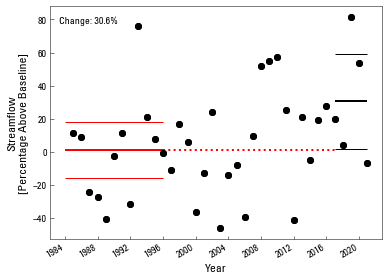

In [98]:
# plot annual streamflow timeseries
parameter='mean flow [cfs]'
statewide_streamflow = ambient_streamflow[parameter].groupby('year').sum(dim='river')
baseline_streamflow = statewide_streamflow.sel(year=ambient_loads.year.dt.year.isin(baseline_years)).mean()

statewide_streamflow_p = statewide_streamflow / baseline_streamflow * 100 - 100

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

running_average_plot(ds1=statewide_streamflow_p,
                     period1=baseline_years,
                     period2=study_years,
                     loc='upper left',
                     ax=ax)


text = ax.set_ylabel(titlecase(f'Streamflow\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_annual_streamflow.png', dpi=150)
    figure_count += 1 

Change in streamflow yields by basin.

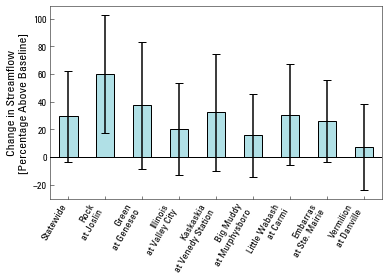

In [69]:
# select streamflow for baseline and current timeperiods
baseline_streamflow = ambient_streamflow.sel(year=ambient_streamflow.year.dt.year.isin(baseline_years))
current_streamflow = ambient_streamflow.sel(year=ambient_streamflow.year.dt.year.isin(study_years))

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_streamflow[parameter], 
                     current_streamflow[parameter], 
                     color='powderblue',
                     ax=ax,
                     statewide=False)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
text = ax.set_ylabel(titlecase(f'Change in Streamflow\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_streamflow_basin.png', dpi=150)
    figure_count += 1 

## Flow-adjusted loads
Flow-adjusted nitrate loads by basin.

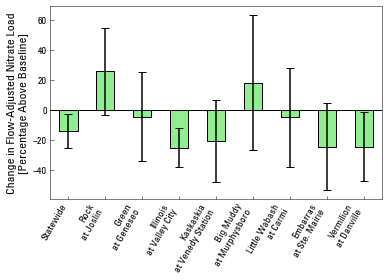

In [99]:
parameter = 'nitrate'
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

total_streamflow = ambient_streamflow.sum(dim='river')['mean flow [cfs]']

plot_change_by_basin(baseline_loads[parameter] / total_streamflow, 
                     current_loads[parameter] / total_streamflow, 
                     color='lightgreen', 
                     ax=ax, 
                     statewide=False)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')

text = ax.set_ylabel(titlecase(f'Change in flow-adjusted {parameter} load\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_{parameter}_basin_fa_yield.png', dpi=150)
    figure_count += 1 

Flow-adjusted phosphorus load by basin

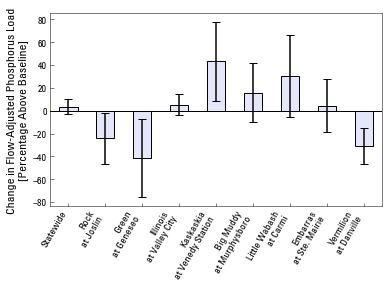

In [101]:
parameter = 'phosphorus'
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

plot_change_by_basin(baseline_loads[parameter] / total_streamflow, 
                     current_loads[parameter] / total_streamflow, 
                     color='lavender', 
                     ax=ax, 
                     statewide=False)

ax.set_xticklabels([ label.get_text().replace(' at ','\nat ') for label in ax.get_xticklabels()], rotation=60, ha='right')
text = ax.set_ylabel(titlecase(f'Change in flow-adjusted {parameter} load\n[percentage above baseline]'))
fig.tight_layout()

if save_figures:
    fig_str = str(figure_count).rjust(2,'0')
    fig.savefig(f'../../figures/{fig_str}_{parameter}_basin_fa_yield.png', dpi=150)
    figure_count += 1 

## Summary
1. Nitrate load increased 10%, primarily from the Rock River
1. Phosphorus load increased 30%, primarily from the Illinois, Kaskaskia, and Little Wabash
1. Streamflow increased 30%
1. Adjusting for streamflow, nitrate loads have declined 10%.
1. Adjusting for streamflow, phosphorus is approximately at the baseline load.


## References
U.S. Geological Survey, 2022, National Water Information System data available on the World Wide Web (USGS Water Data for the Nation), accessed [July 25, 2022], at URL [http://waterdata.usgs.gov/nwis/].